Here is a notebook showing a basic implementation of the Delay Network portion of the Legendre Memory Unit, implemented in Nengo.

First, we define a Nengo `Process` that encapsulates the Delay Network.  This is just arbitrary Python code that will be called every time step and accepts a vector as an input and produces a vector as the output.

In [2]:
import nengo
import numpy as np
import scipy.linalg
from scipy.special import legendre


class LDN(nengo.Process):
    def __init__(self, theta, q, size_in=1):
        self.q = q              # number of internal state dimensions per input
        self.theta = theta      # size of time window (in seconds)
        self.size_in = size_in  # number of inputs

        # Do Aaron's math to generate the matrices
        #  https://github.com/arvoelke/nengolib/blob/master/nengolib/synapses/analog.py#L536
        Q = np.arange(q, dtype=np.float64)
        R = (2*Q + 1)[:, None] / theta
        j, i = np.meshgrid(Q, Q)

        self.A = np.where(i < j, -1, (-1.)**(i-j+1)) * R
        self.B = (-1.)**Q[:, None] * R

        super().__init__(default_size_in=size_in, default_size_out=q*size_in)

    def make_step(self, shape_in, shape_out, dt, rng, state=None):
        state = np.zeros((self.q, self.size_in))

        # Handle the fact that we're discretizing the time step
        #  https://en.wikipedia.org/wiki/Discretization#Discretization_of_linear_state_space_models
        Ad = scipy.linalg.expm(self.A*dt)
        Bd = np.dot(np.dot(np.linalg.inv(self.A), (Ad-np.eye(self.q))), self.B)

        # this code will be called every timestep
        def step_legendre(t, x, state=state):
            state[:] = np.dot(Ad, state) + np.dot(Bd, x[None, :])
            return state.T.flatten()
        return step_legendre

    def get_weights_for_delays(self, r):
        # compute the weights needed to extract the value at time r
        # from the network (r=0 is right now, r=1 is theta seconds ago)
        r = np.asarray(r)
        m = np.asarray([legendre(i)(2*r - 1) for i in range(self.q)])
        return m.reshape(self.q, -1).T

Now we define a Nengo network to feed input into the system.  We also create some readouts to extract the history at various points in time.  We declare `Probe` objects to indicate what data to store so we can plot it later.

In [3]:
model = nengo.Network()
with model:
    stim = nengo.Node(nengo.processes.WhiteSignal(period=10, high=4), size_out=1)
    
    ldn = nengo.Node(LDN(theta=0.5, q=6), size_in=1)
    
    nengo.Connection(stim, ldn, synapse=None)
    
    times = [0, 0.5, 1]
    w = ldn.output.get_weights_for_delays(times)
    readout = nengo.Node(None, size_in=len(times))
    nengo.Connection(ldn, readout, transform=w, synapse=None)
    
    p_stim = nengo.Probe(stim)
    p_ldn = nengo.Probe(ldn)
    p_readout = nengo.Probe(readout)


Now we run our model for 10 seconds.

In [4]:
sim = nengo.Simulator(model)
with sim:
    sim.run(10)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

And we can plot the results.

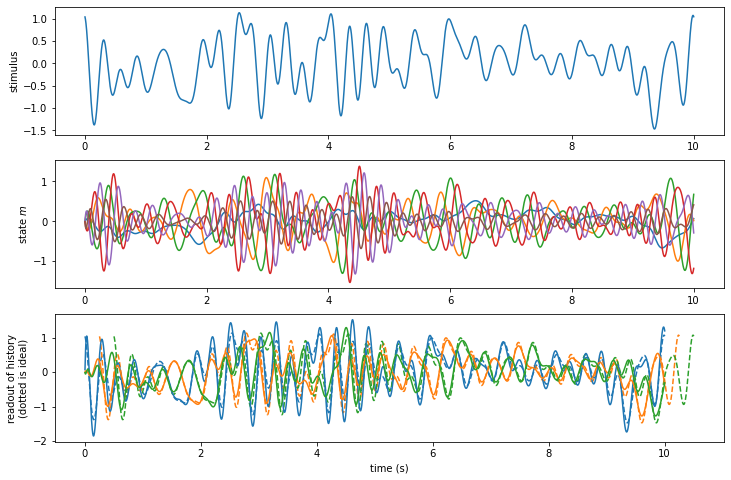

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.subplot(3, 1, 1)
plt.plot(sim.trange(), sim.data[p_stim])
plt.ylabel('stimulus')
plt.subplot(3, 1, 2)
plt.plot(sim.trange(), sim.data[p_ldn])
plt.ylabel('state $m$')
plt.subplot(3, 1, 3)
theta = ldn.output.theta
for t in times:
    plt.plot(sim.trange()+theta*t, sim.data[p_stim], ls='--')
plt.gca().set_prop_cycle(None)
plt.plot(sim.trange(), sim.data[p_readout])
plt.ylabel('readout of history\n(dotted is ideal)')
plt.xlabel('time (s)')
plt.show()